C:\Users\acer\AppData\Local\Temp\ipykernel_11608\787125499.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["MonthlyCharges"] * df["tenure"], inplace=True)


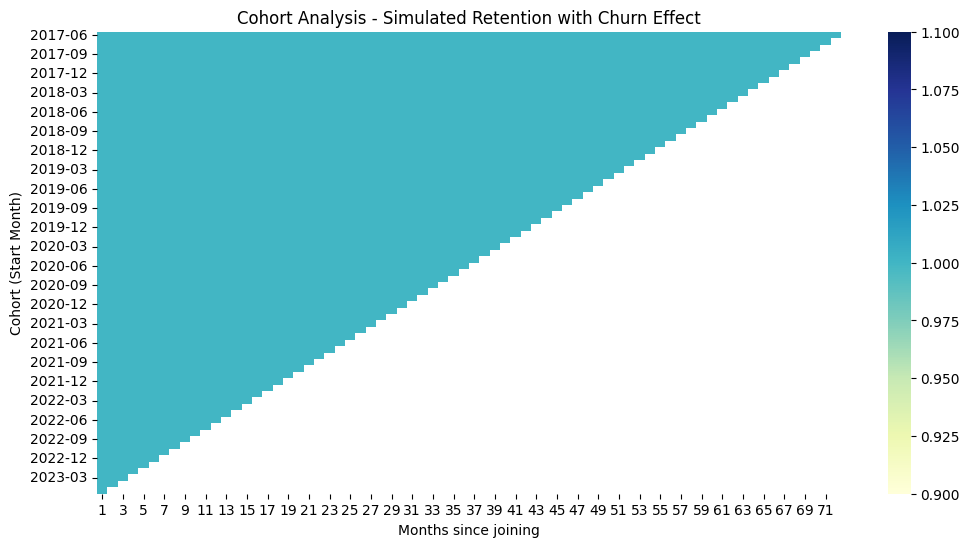

CohortIndex   1    2    3    4    5    6    7    8    9    10  ...   63   64  \
CohortMonth                                                    ...             
2017-06      1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
2017-07      1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
2017-08      1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
2017-09      1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
2017-10      1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   

CohortIndex   65   66   67   68   69   70   71   72  
CohortMonth                                          
2017-06      1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
2017-07      1.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN  
2017-08      1.0  1.0  1.0  1.0  1.0  1.0  NaN  NaN  
2017-09      1.0  1.0  1.0  1.0  1.0  NaN  NaN  NaN  
2017-10      1.0  1.0  1.0  1.0  NaN  NaN  NaN  NaN  

[5 rows x 72 columns]


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Load dataset
df = pd.read_csv(r"C:\Users\acer\Downloads\archive (10)\WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Clean data
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["MonthlyCharges"] * df["tenure"], inplace=True)
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
df = df[df["tenure"] > 0]

# Simulate start months based on tenure
reference_date = dt.datetime(2023, 6, 1)
df["StartDate"] = df["tenure"].apply(lambda x: reference_date - pd.DateOffset(months=int(x)))
df["StartMonth"] = df["StartDate"].dt.to_period("M")

# Define cohorts
df["CohortMonth"] = df["StartMonth"]

# Simulate retention month-by-month with churn drop-off
records = []
for _, row in df.iterrows():
    # for each customer, they are active until their last month
    for i in range(int(row["tenure"])):
        # active months
        records.append((row["customerID"], row["CohortMonth"], i+1))
    # if they churned, we do NOT include months beyond their tenure
    # this automatically stops their record early if Churn=1

activity = pd.DataFrame(records, columns=["customerID", "CohortMonth", "CohortIndex"])

# Count unique customers per cohort-month
cohort_data = activity.groupby(["CohortMonth", "CohortIndex"])["customerID"].nunique().reset_index()

# Pivot
cohort_pivot = cohort_data.pivot(index="CohortMonth", columns="CohortIndex", values="customerID")

# Normalize correctly: divide each month by Month 1
retention = cohort_pivot.divide(cohort_pivot.iloc[:, 0], axis=0)

# Because customers churn over tenure, values will drop < 1
plt.figure(figsize=(12,6))
sns.heatmap(retention, annot=False, fmt=".0%", cmap="YlGnBu")
plt.title("Cohort Analysis - Simulated Retention with Churn Effect")
plt.xlabel("Months since joining")
plt.ylabel("Cohort (Start Month)")
plt.show()

print(retention.head())
